In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

# PJME dataset

In [2]:
df = pd.read_csv('/content/PJME_hourly.csv') # read in PJME Interconnection dataset
df.describe() # view first few rows to visualize columns

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [3]:
df = df.set_index('Datetime') # set index to the datetime column for PJME dataset
df.index = pd.to_datetime(df.index) # convert the values in the datetime column from string to a datetime object
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


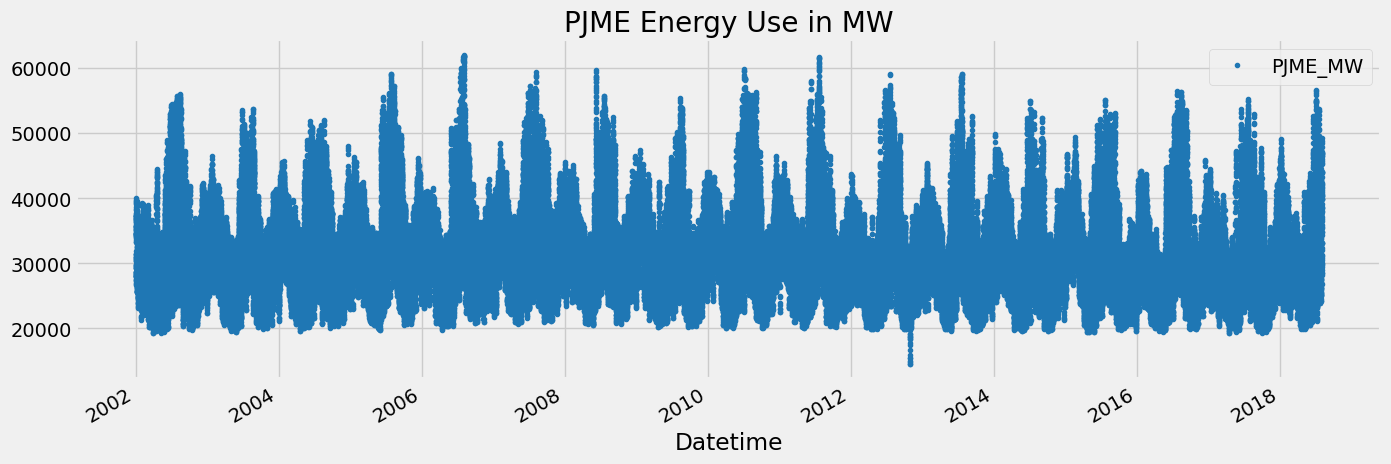

In [4]:
# Visualization of the PJME dataset
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

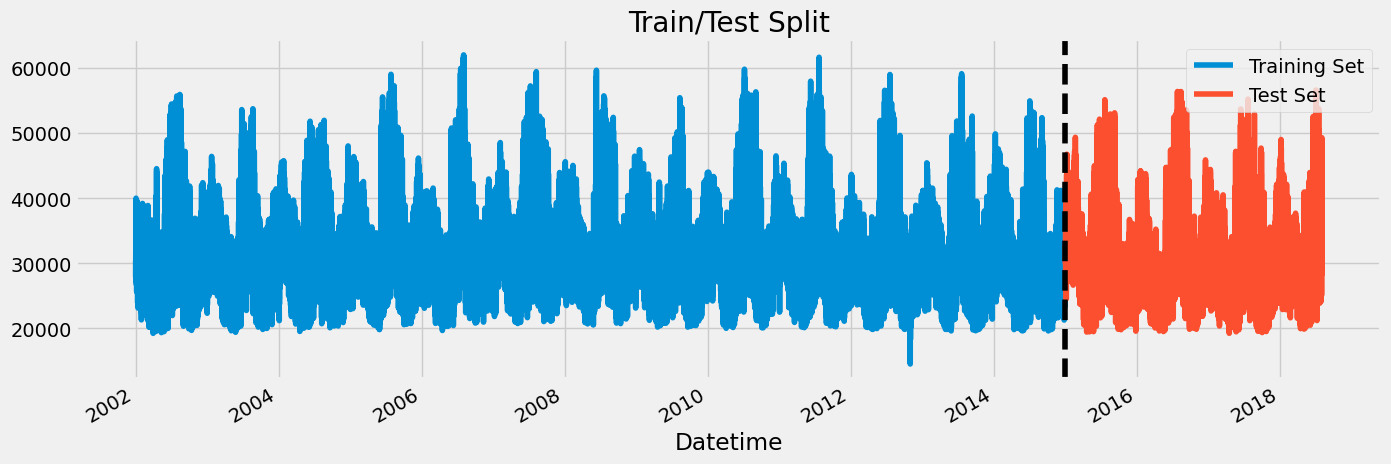

In [5]:
# Train-Test split on PJME dataset

train = df.loc[df.index < '01-01-2015'] # 80% of the dataset representing the training set
test = df.loc[df.index >= '01-01-2015'] # 20% of the dataset representing the test set

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

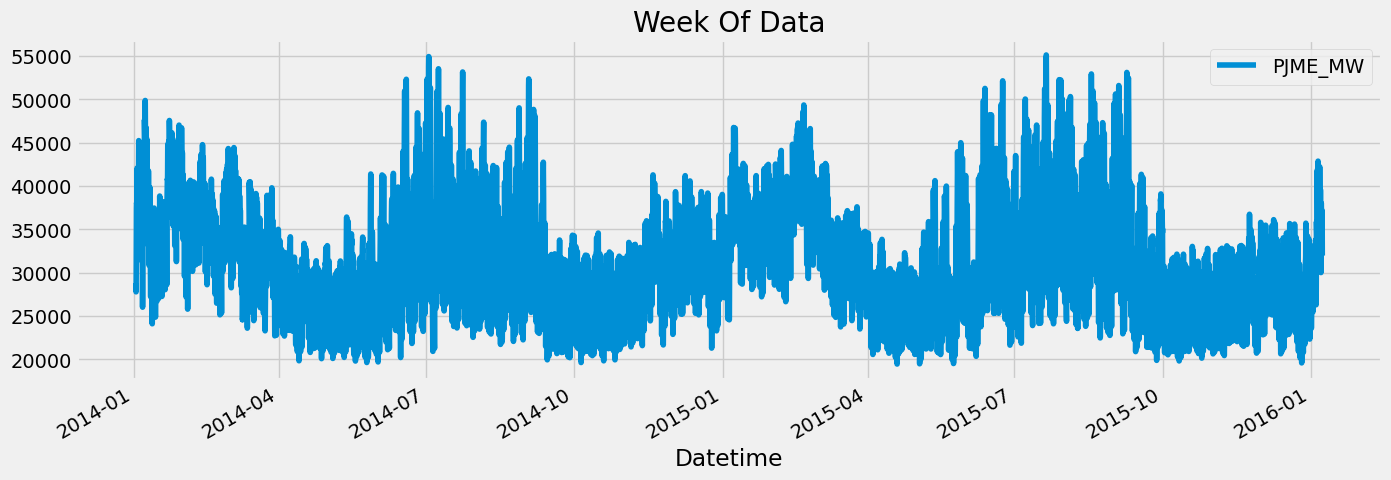

In [5]:
# visualizing 1 week of data
df.loc[(df.index > '01-02-2014') & (df.index < '01-08-2016')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [7]:
# Decomposition of time series data by seasonality
def create_features(df):
    """
    Create time series features based on time series index using the pandas library.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

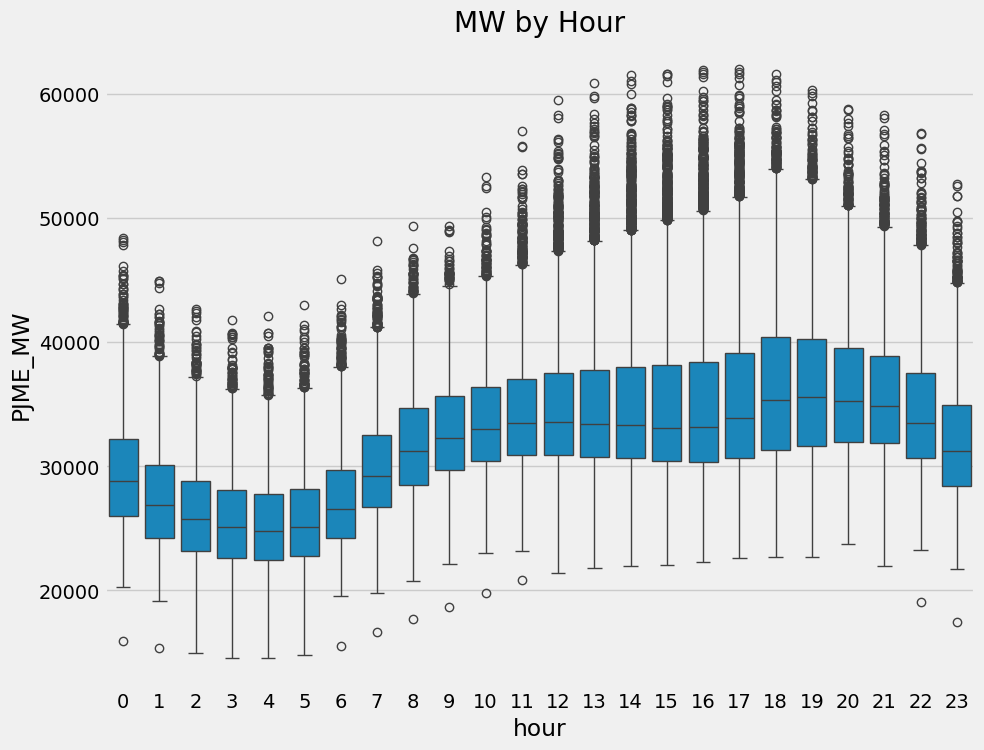

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

<ipython-input-9-69cf918e87c9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


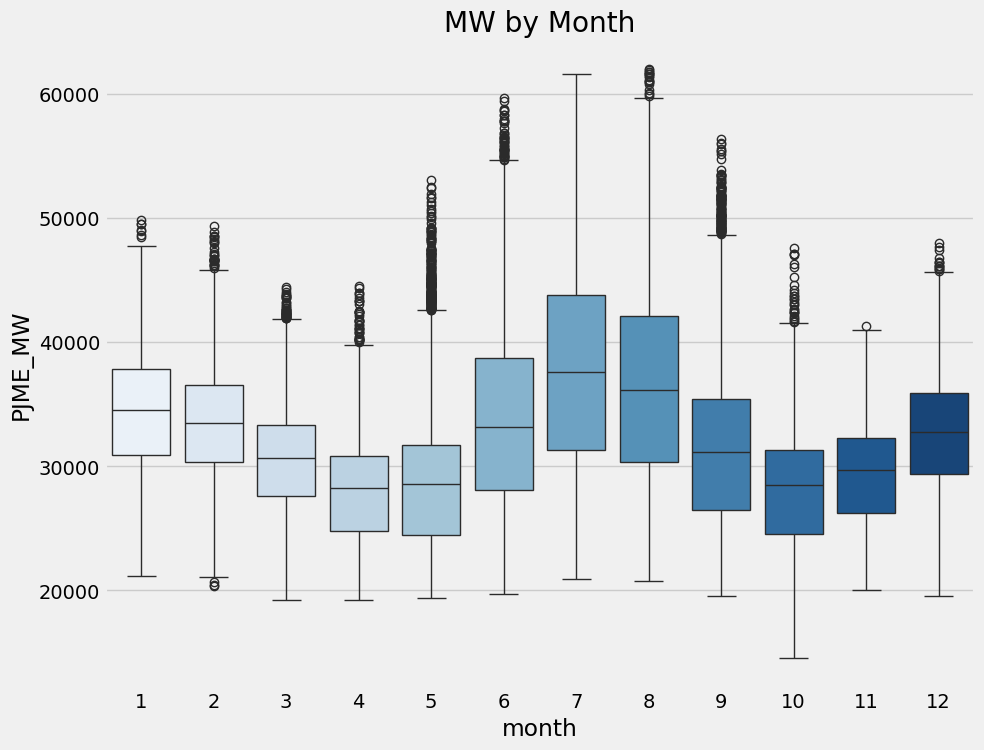

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [18]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
#FEATURES = ['hour', 'dayofyear']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [19]:
# Decision Tree model

param_grid_dt = {
            "splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[1, 3, 5,10,20]
            }

dt = DecisionTreeRegressor(random_state=32)

# Define the cross validation strategy

kfold = KFold(n_splits=5, shuffle=True, random_state=32)

random_search_dt = RandomizedSearchCV(estimator=dt,
                                   param_distributions=param_grid_dt,
                                   n_iter=50,
                                   cv=kfold,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1
                                   )

random_search_dt.fit(X_train, y_train)

print("Best parameters found: ", random_search_dt.best_params_)
print("Best cross-validation score: ", random_search_dt.best_score_)

#best_model = random_search_dt.best_estimator_
best_model = dt.fit(X_train, y_train)

# Predictions on training set
y_train_pred_dt = best_model.predict(X_train)

# Predictions on test set
y_test_pred_dt = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_train_dt = mean_squared_error(y_train, y_train_pred_dt)
mse_test_dt = mean_squared_error(y_test, y_test_pred_dt)

# Calculate Root Mean Squared Error (RMSE)
rmse_train_dt = np.sqrt(mse_train_dt)
rmse_test_dt = np.sqrt(mse_test_dt)

total_absolute_error = np.sum(np.abs(y_test - y_test_pred_dt))

# Calculate the sum of actual values
total_actual_values = np.sum(np.abs(y_test))

# Calculate TAE as a percentage
tae_percentage = (total_absolute_error / total_actual_values) * 100

mean_absolute_error = np.mean(np.abs(y_test - y_test_pred_dt))

# Print results
print(f"Mean Squared Error of training set: {mse_train_dt}\n")
print(f"Root Mean Squared Error of training set: {rmse_train_dt}\n")

print(f"Mean Squared Error of test set: {mse_test_dt: .2f}\n")
print(f"Root Mean Squared Error of test set: {rmse_test_dt: .2f}\n")

print(f"Mean Absolute Error (MAE): {mean_absolute_error:.2f}\n")
print(f"Total Absolute Error (TAE) Percentage: {tae_percentage:.2f}%\n")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
115 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best parameters found:  {'splitter': 'random', 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 4, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'max_depth': 5}
Best cross-validation score:  -27934784.96282481
Mean Squared Error of training set: 2.951038393343047

Root Mean Squared Error of training set: 1.7178586651244179

Mean Squared Error of test set:  22083235.42

Root Mean Squared Error of test set:  4699.28

Mean Absolute Error (MAE): 3456.51

Total Absolute Error (TAE) Percentage: 11.04%



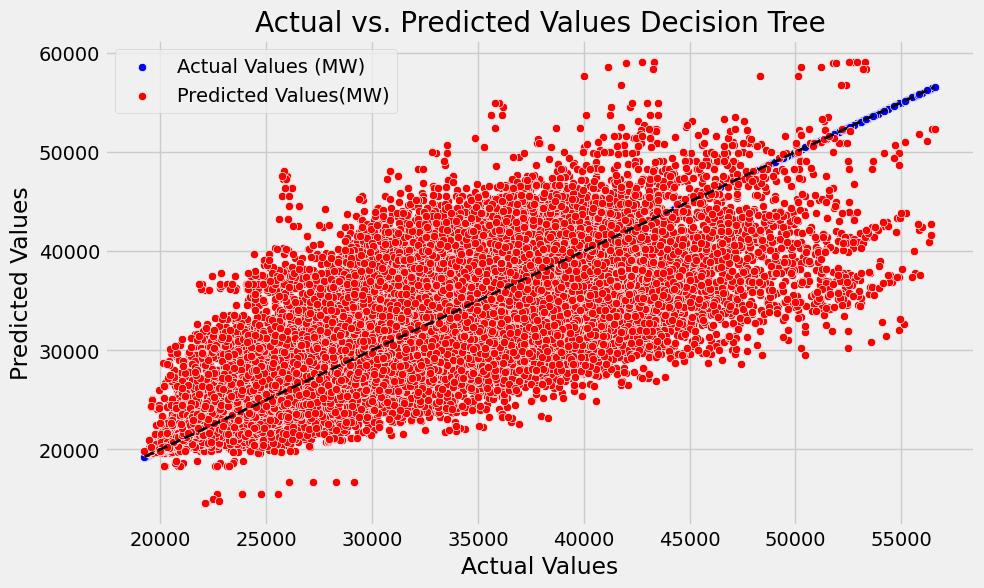

In [26]:
# Scatterplot of actual vs. predicted values
plt.figure(figsize=(10, 6))

# Plotting actual values
sns.scatterplot(x=y_test, y=y_test, label='Actual Values (MW)', color='blue')

# Plotting predicted values
sns.scatterplot(x=y_test, y=y_test_pred_dt, label='Predicted Values(MW)', color='red')

# Adding a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)

plt.title('Actual vs. Predicted Values Decision Tree')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [24]:
# Random Forest model w/ all features

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf = RandomForestRegressor(n_estimators=205,
                           min_samples_split=3,
                           min_samples_leaf=2,
                           max_features='sqrt',
                           max_depth=20,
                           random_state=32)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid_rf,
                                   n_iter=50, cv=kfold,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1,
                                    error_score=True,
                                    verbose=10
                                   )
random_search_rf.fit(X_train, y_train)

print("Best parameters found: ", random_search_rf.best_params_)
print("Best cross-validation score: ", random_search_rf.best_score_)

best_model = random_search_rf.best_estimator_

# Predictions on training set
y_train_pred_rf = best_model.predict(X_train)

# Predictions on test set
y_test_pred_rf = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse_train_rf = np.sqrt(mse_train_rf)
rmse_test_rf = np.sqrt(mse_test_rf)

total_absolute_error = np.sum(np.abs(y_test - y_test_pred_rf))

# Calculate the sum of actual values
total_actual_values = np.sum(np.abs(y_test))

# Calculate TAE as a percentage
tae_percentage = (total_absolute_error / total_actual_values) * 100

mean_absolute_error = np.mean(np.abs(y_test - y_test_pred_rf))

# Print results
print(f"Mean Squared Error of training set: {mse_train_rf}")
print(f"Root Mean Squared Error of training set: {rmse_train_rf}")


print(f"Mean Squared Error of test set: {mse_test_rf}")
print(f"Root Mean Squared Error of test set: {rmse_test_rf}")

print(f"Mean Absolute Error (MAE): {mean_absolute_error:.2f}")
print(f"Total Absolute Error (TAE) Percentage: {tae_percentage:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best cross-validation score:  -2112178.087426477
Mean Squared Error of training set: 263944.8765407836
Root Mean Squared Error of training set: 513.7556584026921
Mean Squared Error of test set: 17213137.860939145
Root Mean Squared Error of test set: 4148.871878106041
Mean Absolute Error (MAE): 3095.30
Total Absolute Error (TAE) Percentage: 9.88%


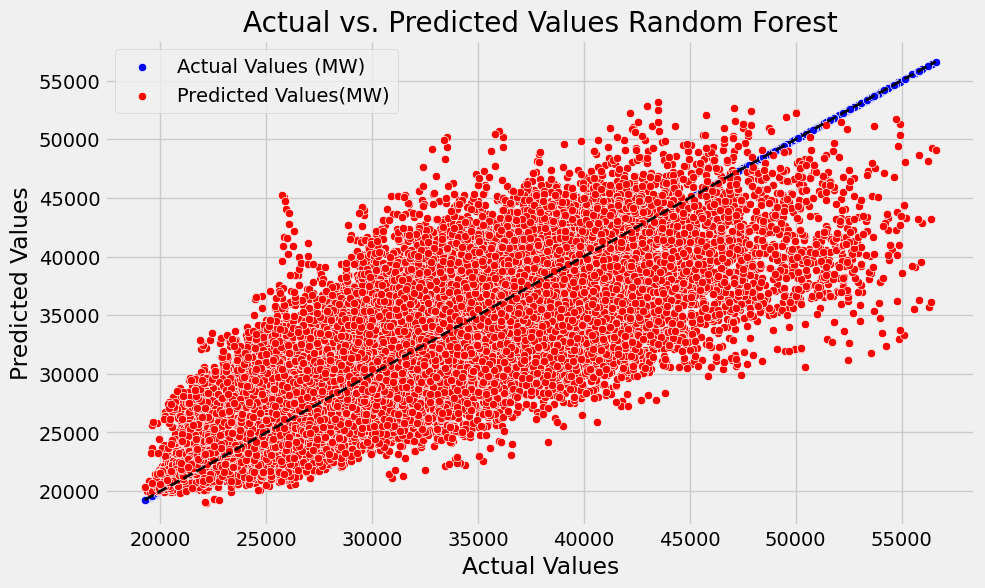

In [27]:
# Scatterplot of actual vs. predicted values Random Forest
plt.figure(figsize=(10, 6))

# Plotting actual values
sns.scatterplot(x=y_test, y=y_test, label='Actual Values (MW)', color='blue')

# Plotting predicted values
sns.scatterplot(x=y_test, y=y_test_pred_rf, label='Predicted Values(MW)', color='red')

# Adding a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)

plt.title('Actual vs. Predicted Values Random Forest')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

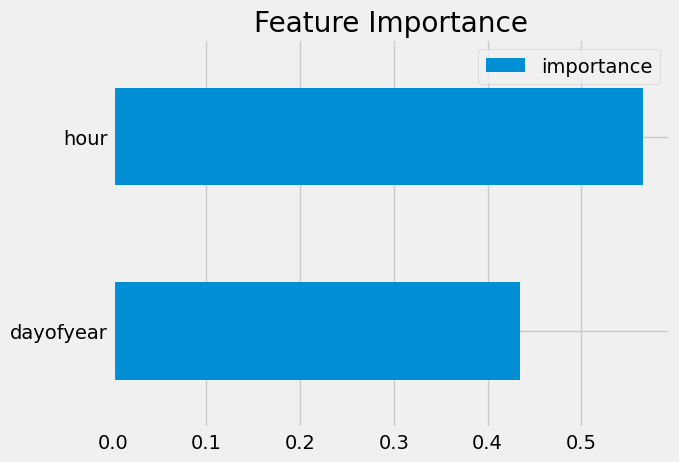

In [116]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=train.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [98]:
# Random Forest model with top 2 important features

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf = RandomForestRegressor(n_estimators=205,
                           min_samples_split=3,
                           min_samples_leaf=2,
                           max_features='sqrt',
                           max_depth=20,
                           random_state=32)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

random_search_rf = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid_rf,
                                   n_iter=50, cv=kfold,
                                   scoring='neg_mean_squared_error',
                                   random_state=42,
                                   n_jobs=-1,
                                    error_score=True,
                                    verbose=10
                                   )
random_search_rf.fit(X_train, y_train)

print("Best parameters found: ", random_search_rf.best_params_)
print("Best cross-validation score: ", random_search_rf.best_score_)

best_model = random_search_rf.best_estimator_

# Predictions on training set
y_train_pred_rf = best_model.predict(X_train)

# Predictions on test set
y_test_pred_rf = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse_train_rf = np.sqrt(mse_train_rf)
rmse_test_rf = np.sqrt(mse_test_rf)

total_absolute_error = np.sum(np.abs(y_test - y_test_pred_rf))

# Calculate the sum of actual values
total_actual_values = np.sum(np.abs(y_test))

# Calculate TAE as a percentage
tae_percentage = (total_absolute_error / total_actual_values) * 100

mean_absolute_error = np.mean(np.abs(y_test - y_test_pred_rf))

# Print results
print(f"Mean Squared Error of training set: {mse_train_rf}")
print(f"Root Mean Squared Error of training set: {rmse_train_rf}")


print(f"Mean Squared Error of test set: {mse_test_rf}")
print(f"Root Mean Squared Error of test set: {rmse_test_rf}")

print(f"Mean Absolute Error (MAE): {mean_absolute_error:.2f}")
print(f"Total Absolute Error (TAE) Percentage: {tae_percentage:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best cross-validation score:  -12726646.336478993
Mean Squared Error of training set: 12347497.875521084
Root Mean Squared Error of training set: 3513.900663866451
Mean Squared Error of test set: 15824941.211138034
Root Mean Squared Error of test set: 3978.057467048212
Mean Absolute Error (MAE): 3125.55
Total Absolute Error (TAE) Percentage: 9.98%
